In [1]:
import torch
from torch import nn

torch.__version__

'2.0.0a0'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# always start small and increase when necessary
# ml is an iterative process

In [4]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
images_path = data_path / "pizza_steak_sushi"

if images_path.is_dir():
    print(f"{images_path} directory exists.")
else:
    print(f"Did not find {images_path} directory, creating one...")
    images_path.mkdir(parents=True, exist_ok=True)
    
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(images_path)

data/pizza_steak_sushi directory exists.


In [5]:
# now, become one with the data!

In [6]:
import os
def walk_through_dir(dir_path: str):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(images_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [7]:
train_dir = images_path / "train"
test_dir = images_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [8]:
# now visualize, visualize, visualize!

Random image pat: data/pizza_steak_sushi/test/pizza/195160.jpg
Image class: pizza
CHW: RGB, 384, 512


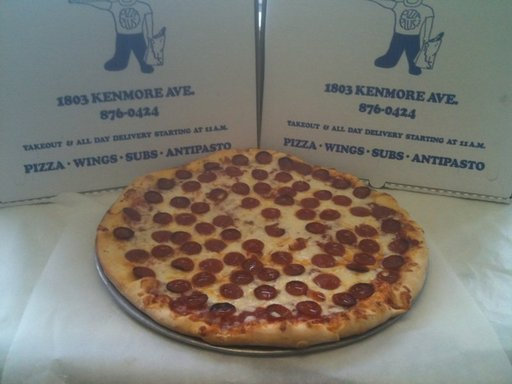

In [9]:
import random
from PIL import Image # python image library

random.seed(42)

images_path_list = list(images_path.glob("*/*/*.jpg"))

random_image_path = random.choice(images_path_list) # get a random image file from all the imgs

image_class = random_image_path.parent.stem # parent dir name

img = Image.open(random_image_path)

print(f"Random image pat: {random_image_path}")
print(f"Image class: {image_class}")
print(f"CHW: {img.mode}, {img.height}, {img.width}")
img

In [10]:
# to be able to compute with we need to 
# 1. turn data in tensors 
# 2. turn it into Dataset and DataLoader

In [11]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms # transforms is for formatting images
# data augmentation: the practice of altering data to make it harder for a model to learn

In [12]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5), # 50% probability of flip
    transforms.ToTensor() # pixel values to 0-255 and between 0.0 and 1.0
])

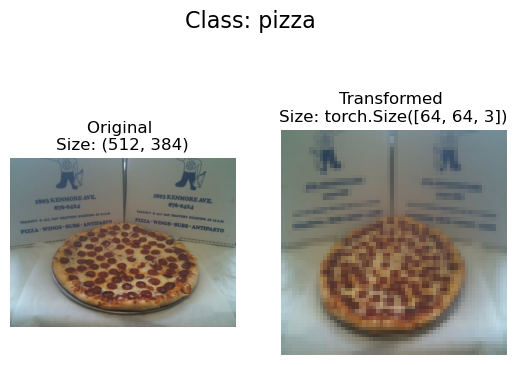

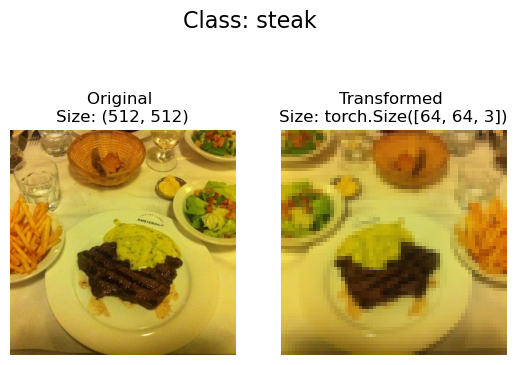

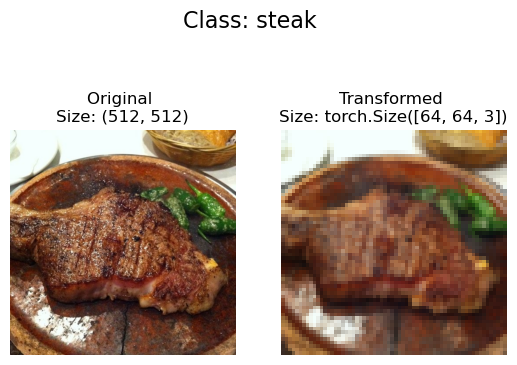

In [13]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(images_path_list,
                       transform=data_transform,
                       n=3)

In [14]:
# more pixels in an image allows for more data to train on, 
# but also more computation required

In [15]:
# turn data into a torch Dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                 transform=data_transform,
                                 target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [16]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
len(train_data), len(test_data)

(225, 75)

In [19]:
# images are now in 3x64x64 tensors storing floats from 0.0-1.0
train_data[0][0].dtype

torch.float32

Original shape: torch.Size([3, 64, 64]) -> [CHW]
Original shape: torch.Size([64, 64, 3]) -> [CHW]


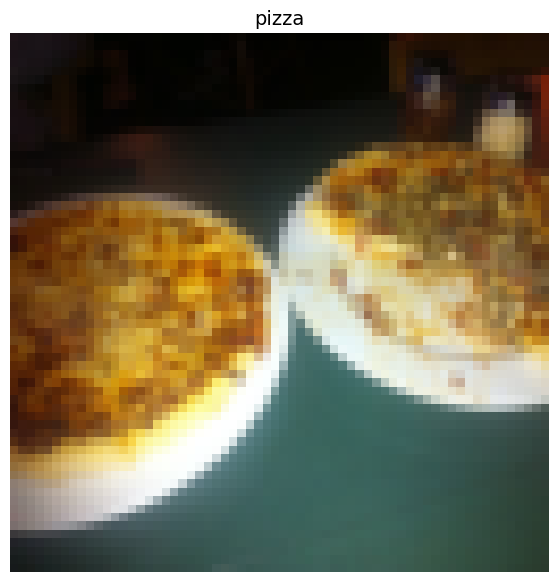

In [20]:
img, label = train_data[0][0], train_data[0][1]
img_permute = img.permute(1, 2, 0)

print(f"Original shape: {img.shape} -> [CHW]")
print(f"Original shape: {img_permute.shape} -> [CHW]")

plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [21]:
# Turn torch Dataset into a Dataloader (makes the samples iterable)

In [22]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=1,
                            num_workers=1,
                            shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79ace90a7fd0>,
 <torch.utils.data.dataloader.DataLoader at 0x79ace90975d0>)

In [23]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [24]:
# making our own custom Dataset class for custom data
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [25]:
from torch.utils.data import Dataset
class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir: str, transform=None) -> None:
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = self.find_classes(targ_dir)
      
    @staticmethod
    def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # optional for subclassses
    def __len__(self) -> int:
        return len(self.paths)
    
    # required for subclasses
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [26]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [27]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                     transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                    transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x79ace911e510>,
 <__main__.ImageFolderCustom at 0x79ace911e110>)

In [28]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [29]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [30]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                         classes: List[str]=None,
                         n: int=10,
                         display_shape: bool=True,
                         seed: int=None):
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 to remove errors")
    if seed: random.seed(seed)
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(16,8))
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        targ_image_adjust = targ_image.permute(1, 2, 0)
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape: title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)
    

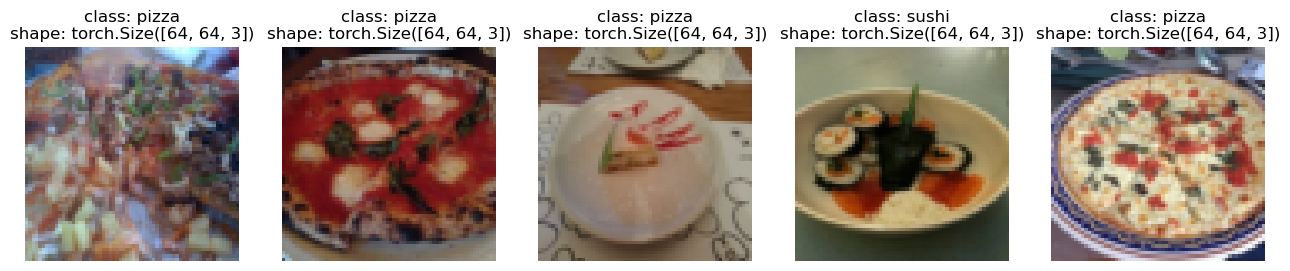

In [31]:
display_random_images(train_data,
                     n=5,
                     classes=class_names,
                     seed=None)

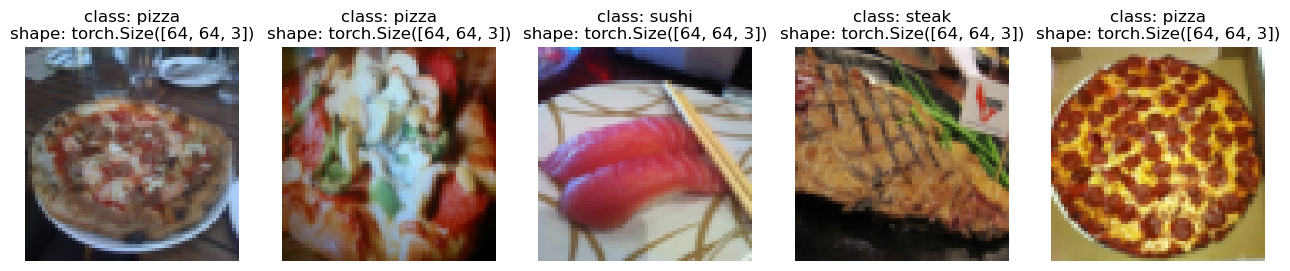

In [32]:
display_random_images(train_data_custom,
                     n=5,
                     classes=class_names,
                     seed=None)

In [34]:
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                    batch_size=1,
                                    num_workers=0, # subprocesses
                                    shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                   batch_size=1,
                                   num_workers=0,
                                   shuffle=False)

In [40]:
# data transforms (also called data augmentation)
#  this is done to artificially increase the diversity of the data set
# see torchvision.transforms for all possible transforms

In [41]:
img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channel, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channel, height, width]
Label shape: torch.Size([1])


In [42]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # intensity of transforms
    transforms.ToTensor() # last to get between 0 and 1
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [43]:
train_transforms, test_transforms

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
     ToTensor()
 ))

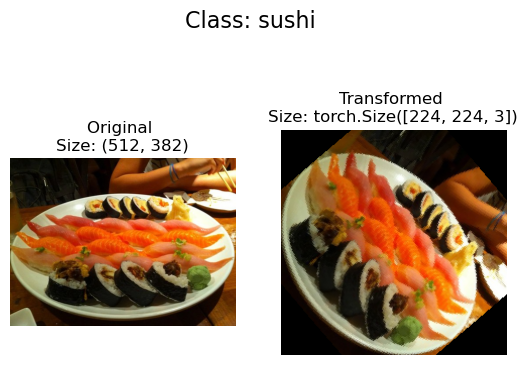

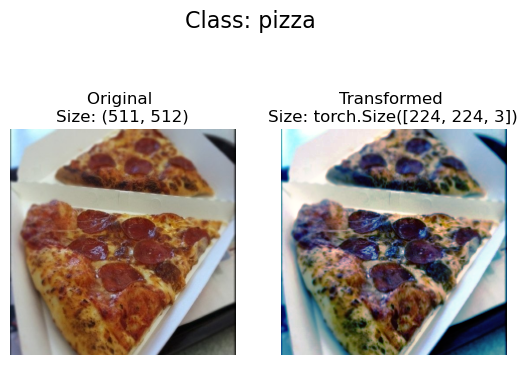

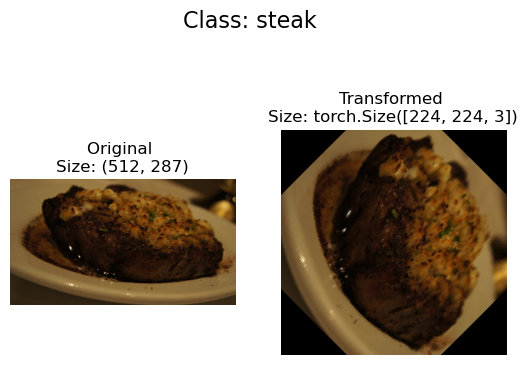

In [47]:
# testing our data augmentation out
image_path_list = list(images_path.glob("*/*/*.jpg"))

plot_transformed_images(image_paths=image_path_list,
                       transform=train_transforms,
                       n=3,
                       seed=None)

In [48]:
# classification here